In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.distributions import Normal
from torch.utils.data import Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.distributions import Categorical, Normal, StudentT
import torch.distributions as dist
from torch.optim import SGD
from collections import deque
from tqdm import trange
import tqdm
import copy

In [2]:
from data import *
from models import *

In [3]:
# Load MNIST dataset with specified transforms
# always use ToTensor() as first transform
# possible transforms: RandomRotation, RandomCrop, GaussianBlur
# avoid Normalize (already done), RandomHorizontalFlip (for MNIST), RandomVerticalFlip (for MNIST)
transform = tr.Compose([tr.ToTensor()])
augmentations = tr.Compose([tr.RandomRotation(15)])

dataset = Data("FashionMNIST", augmentations = None)
train_data, test_data = dataset.get_data()

# Print some information about the dataset
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

# Create data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Train data size:  60000
Test data size:  10000


C:\Users\jorge\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


tensor(9)


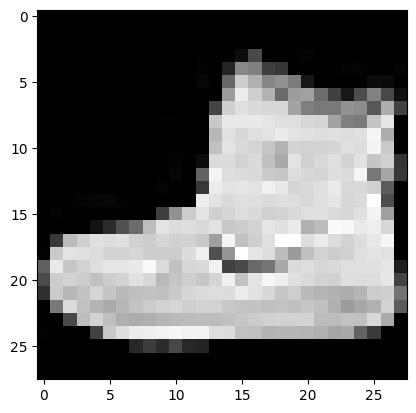

In [4]:
# display some images
image_index = 0
feature = dataset.trainset[image_index][0]
# feature = dataset.trainset_extra[image_index][0] # to display images from the augmented dataset
label = train_data[image_index][1]
print(label)
plt.imshow(feature.squeeze(), cmap='gray')
plt.show()

In [29]:
# Temperature for the posterior
Temperature_posterior = 1

# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_dim = 28*28, output_dim = 10, hidden_dims = [100], Temperature = Temperature_posterior)
print(model)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)

# train the model
epochs = 10
num_samples = 5

for epoch in tqdm.trange(epochs):
    num_batches = len(train_loader)
    for i, (x, y) in enumerate(train_loader):
        # zero the gradients
        optimizer.zero_grad()

        # reshape the data
        x = x.view(-1, 28*28)

        # save weights
        weights = []

        # reset loss
        loss = torch.tensor(0.0)

        # forward pass
        for e in range(num_samples):
            output, kl_divergence, w = model(x)
            loss += (F.nll_loss(F.softmax(output, dim = 1), y, reduction = "sum") + kl_divergence/num_batches)/num_samples
        
        weights.append(w)
            

        # backward pass
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # accuracy
        acc = (output.argmax(dim = 1) == y).float().mean()

        # print the loss
        if i % 100 == 0:
            print(f"Epoch: {epoch} | Batch: {i} | Loss: {loss.item()}, accuracy: {acc.item()}")
            scheduler.step()

Bayesian_Neural_Network(
  (layers): ModuleList(
    (0): Linear_Layer(
      (weight_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weight_posterior): MultivariateDiagonalGaussian()
      (bias_posterior): MultivariateDiagonalGaussian()
    )
    (1): Linear_Layer(
      (weight_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weight_posterior): MultivariateDiagonalGaussian()
      (bias_posterior): MultivariateDiagonalGaussian()
    )
  )
  (activation): ReLU(inplace=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Batch: 0 | Loss: -12.70931339263916, accuracy: 0.0703125
Epoch: 0 | Batch: 100 | Loss: -14.823896408081055, accuracy: 0.109375
Epoch: 0 | Batch: 200 | Loss: -10.477163314819336, accuracy: 0.0859375
Epoch: 0 | Batch: 300 | Loss: -12.029365539550781, accuracy: 0.125
Epoch: 0 | Batch: 400 | Loss: -19.094501495361328, accuracy: 0.203125


 10%|█         | 1/10 [00:19<02:51, 19.09s/it]

Epoch: 1 | Batch: 0 | Loss: -20.439247131347656, accuracy: 0.171875
Epoch: 1 | Batch: 100 | Loss: -24.715211868286133, accuracy: 0.2109375
Epoch: 1 | Batch: 200 | Loss: -26.704917907714844, accuracy: 0.1171875
Epoch: 1 | Batch: 300 | Loss: -33.936302185058594, accuracy: 0.3125
Epoch: 1 | Batch: 400 | Loss: -30.180419921875, accuracy: 0.25


 20%|██        | 2/10 [00:38<02:33, 19.13s/it]

Epoch: 2 | Batch: 0 | Loss: -27.852548599243164, accuracy: 0.21875
Epoch: 2 | Batch: 100 | Loss: -33.46372604370117, accuracy: 0.3203125
Epoch: 2 | Batch: 200 | Loss: -41.19282531738281, accuracy: 0.3203125
Epoch: 2 | Batch: 300 | Loss: -44.96277618408203, accuracy: 0.3828125
Epoch: 2 | Batch: 400 | Loss: -43.881683349609375, accuracy: 0.28125


 30%|███       | 3/10 [00:58<02:17, 19.67s/it]

Epoch: 3 | Batch: 0 | Loss: -49.911441802978516, accuracy: 0.3828125
Epoch: 3 | Batch: 100 | Loss: -38.36311340332031, accuracy: 0.2421875
Epoch: 3 | Batch: 200 | Loss: -58.173980712890625, accuracy: 0.5
Epoch: 3 | Batch: 300 | Loss: -55.2803955078125, accuracy: 0.421875
Epoch: 3 | Batch: 400 | Loss: -50.337772369384766, accuracy: 0.3984375


 40%|████      | 4/10 [01:18<01:58, 19.83s/it]

Epoch: 4 | Batch: 0 | Loss: -58.936126708984375, accuracy: 0.484375
Epoch: 4 | Batch: 100 | Loss: -54.13908767700195, accuracy: 0.4765625
Epoch: 4 | Batch: 200 | Loss: -50.87129211425781, accuracy: 0.3515625
Epoch: 4 | Batch: 300 | Loss: -63.838584899902344, accuracy: 0.5390625
Epoch: 4 | Batch: 400 | Loss: -66.62382507324219, accuracy: 0.5


 50%|█████     | 5/10 [01:38<01:40, 20.01s/it]

Epoch: 5 | Batch: 0 | Loss: -72.25790405273438, accuracy: 0.5546875
Epoch: 5 | Batch: 100 | Loss: -66.5965805053711, accuracy: 0.484375
Epoch: 5 | Batch: 200 | Loss: -63.221500396728516, accuracy: 0.484375
Epoch: 5 | Batch: 300 | Loss: -77.85186004638672, accuracy: 0.546875
Epoch: 5 | Batch: 400 | Loss: -64.8832778930664, accuracy: 0.546875


 60%|██████    | 6/10 [01:59<01:20, 20.09s/it]

Epoch: 6 | Batch: 0 | Loss: -76.20370483398438, accuracy: 0.6328125
Epoch: 6 | Batch: 100 | Loss: -73.27842712402344, accuracy: 0.5390625
Epoch: 6 | Batch: 200 | Loss: -70.29612731933594, accuracy: 0.5390625
Epoch: 6 | Batch: 300 | Loss: -76.53894805908203, accuracy: 0.609375
Epoch: 6 | Batch: 400 | Loss: -67.82331085205078, accuracy: 0.5625


 70%|███████   | 7/10 [02:19<01:00, 20.06s/it]

Epoch: 7 | Batch: 0 | Loss: -74.81932067871094, accuracy: 0.59375
Epoch: 7 | Batch: 100 | Loss: -78.6496353149414, accuracy: 0.609375
Epoch: 7 | Batch: 200 | Loss: -72.25154876708984, accuracy: 0.578125
Epoch: 7 | Batch: 300 | Loss: -74.00775146484375, accuracy: 0.59375
Epoch: 7 | Batch: 400 | Loss: -82.50737762451172, accuracy: 0.5859375


 80%|████████  | 8/10 [02:39<00:40, 20.06s/it]

Epoch: 8 | Batch: 0 | Loss: -86.12056732177734, accuracy: 0.7109375
Epoch: 8 | Batch: 100 | Loss: -77.58885955810547, accuracy: 0.5625
Epoch: 8 | Batch: 200 | Loss: -81.9466552734375, accuracy: 0.6796875
Epoch: 8 | Batch: 300 | Loss: -84.63333129882812, accuracy: 0.65625
Epoch: 8 | Batch: 400 | Loss: -83.11550903320312, accuracy: 0.6484375


 90%|█████████ | 9/10 [02:59<00:20, 20.06s/it]

Epoch: 9 | Batch: 0 | Loss: -78.94570922851562, accuracy: 0.578125
Epoch: 9 | Batch: 100 | Loss: -86.2344970703125, accuracy: 0.6796875
Epoch: 9 | Batch: 200 | Loss: -71.75973510742188, accuracy: 0.546875
Epoch: 9 | Batch: 300 | Loss: -78.02259063720703, accuracy: 0.5625
Epoch: 9 | Batch: 400 | Loss: -79.94757843017578, accuracy: 0.640625


100%|██████████| 10/10 [03:20<00:00, 20.05s/it]


In [30]:
# predict class probabilities for the test data
x_test = test_data[:][0].clone().detach()
y_test = test_data[:][1].clone().detach()

predicted_probs = model.predict_probs(x_test, 100)
top_probs = torch.max(predicted_probs, axis = 1)
predicted_class = torch.argmax(predicted_probs, axis = 1)

accuracy = torch.sum(predicted_class == y_test) / len(y_test)
print(f"Accuracy: {accuracy}")

print(torch.hstack((torch.tensor(predicted_class).unsqueeze(1), torch.tensor(y_test).unsqueeze(1))))

Accuracy: 0.6341999769210815
tensor([[9, 9],
        [2, 2],
        [1, 1],
        ...,
        [8, 8],
        [1, 1],
        [7, 5]])


C:\Users\jorge\AppData\Local\Temp\ipykernel_9988\2444513940.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.hstack((torch.tensor(predicted_class).unsqueeze(1), torch.tensor(y_test).unsqueeze(1))))


In [15]:
import torchmetrics
from torchmetrics.functional import calibration_error

calibration_error(predicted_probs, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)

tensor(0.2628)

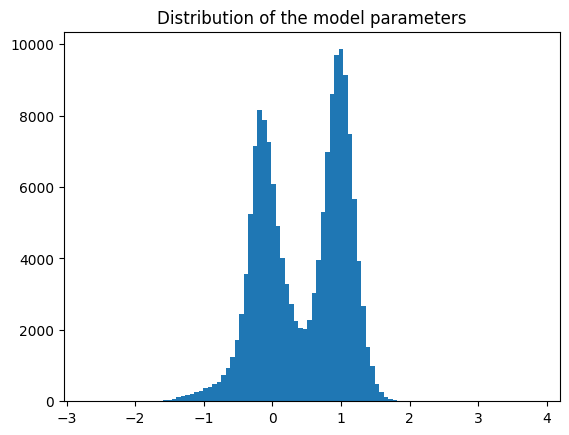

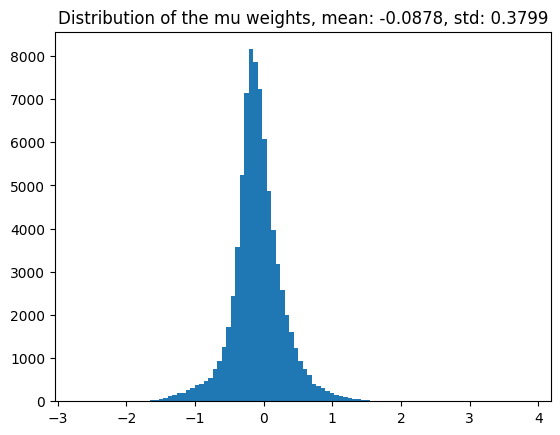

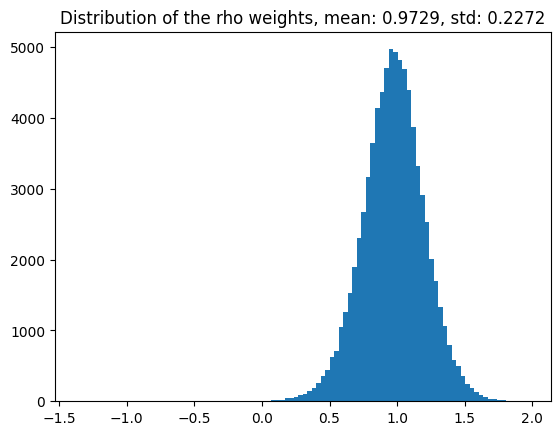

In [16]:
# plot the distribution of the model parameters

# get all parameters in a vector
params = torch.cat([p.view(-1) for p in model.parameters()])
plt.hist(params.detach().numpy(), bins = 100)
plt.title("Distribution of the model parameters")
plt.show()

# plot the distribution of all the mu weights
mu_weights = torch.cat([p[1].view(-1) for p in model.named_parameters() if "mu" in p[0]])
mean = mu_weights.mean()
std = mu_weights.std()
plt.hist(mu_weights.detach().numpy(), bins = 100)
plt.title(f"Distribution of the mu weights, mean: {mean.item():.4f}, std: {std.item():.4f}")
plt.show()

# plot the distribution of all the rho weights
rho_weights = torch.cat([p[1].view(-1) for p in model.named_parameters() if "rho" in p[0]])
mean = rho_weights.mean()
std = rho_weights.std()
plt.hist(rho_weights.detach().numpy(), bins = 100)
plt.title(f"Distribution of the rho weights, mean: {mean.item():.4f}, std: {std.item():.4f}")
plt.show()


In [31]:
for w in weights:
    print(w[0].shape)
    print(w[1].shape)

torch.Size([78500])
torch.Size([1010])


1


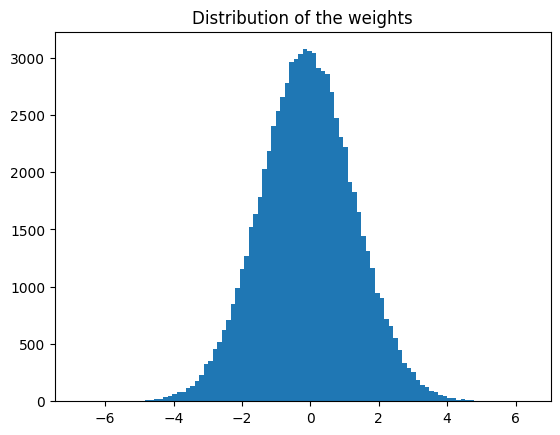

In [32]:
# flatten the weights
print(len(weights))
weight_list = torch.cat([torch.cat(w).view(-1) for w in weights])

# plot the distribution of the weights
plt.hist(weight_list.detach().numpy(), bins = 100)
plt.title("Distribution of the weights")
plt.show()